In [1]:
# import libraries
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import scipy.stats as stats
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
# import location and price df
df_location_price = pd.read_pickle('data/yelp_price_location.pkl')

In [73]:
df_location_price.head(2)

,categories,price,rating,review_count,Lat,Lon,state
0,Salad|Seafood|American (Traditional),2,3.5,372,38.997397,-77.026797,MD
1,Pizza|American (New)|Salad,2,3.5,192,38.919506,-77.224311,VA


In [5]:
# look at review count and rating vs state first split into 3 groups
# DC, VA, MD
DC = df_location_price[df_location_price.state == 'DC'][[
    'state', 'review_count', 'rating']].reset_index()
MD = df_location_price[df_location_price.state == 'MD'][[
    'state', 'review_count', 'rating']].reset_index()
VA = df_location_price[df_location_price.state == 'VA'][[
    'state', 'review_count', 'rating']].reset_index()

In [11]:
# normality test 
stats.normaltest(DC.rating)
stats.normaltest(MD.rating)
stats.normaltest(VA.rating)
stats.normaltest(DC.review_count)
stats.normaltest(MD.review_count)
stats.normaltest(VA.review_count)
# not normal 

NormaltestResult(statistic=4771.567353319586, pvalue=0.0)

In [36]:
# randomly generate 100 samples for 100000 times 
def boostrap_sample(samples, n):
    return np.random.choice(samples, size = n, replace = True )
# generate sample means
def sampling(samples, n, num):
    sample_means = []
    for i in range(num):
        sample_means.append(boostrap_sample(samples, n).mean())
    return sample_means
def sample_category(samples,n,num, feature):
    return sampling(samples[feature], n, num)

In [37]:
# set up tukey hsd for post anova with significance
def tukey_hsd(datas, group_names, colname):
    '''
    datas: from one_way_anova function, a list of data for each group
    group_names: a list of strings with group names, datas order should be same as group_names
    colname: string, the category to compare 
    return tukeyhsd table result and stacked table 
    '''
    # arrange to proper df format for tukey hsd
    df = pd.DataFrame()
    for i in range(len(group_names)):
        df[group_names[i]] = datas[i]
    stacked_df = df.stack().reset_index()
    stacked_df = stacked_df.rename(
        columns={'level_0': 'id', 'level_1': 'state', 0: colname})
    MultiComp = MultiComparison(stacked_df[colname],
                                stacked_df['state'])
    return (stacked_df, MultiComp.tukeyhsd().summary())

In [38]:
# create datasets for DC, MD, VA with review_count
DC_review = sample_category(DC,100,100000,'review_count')
MD_review = sample_category(MD,100,100000,'review_count')
VA_review = sample_category(VA,100,100000,'review_count')

In [39]:
stats.f_oneway(DC_review, MD_review, VA_review)

F_onewayResult(statistic=353154.1970175773, pvalue=0.0)

In [41]:
tukey_hsd([DC_review,MD_review,VA_review], ['DC','MD','VA'],'review_count')[1]
# MD has the most traffic then VA then DC

group1,group2,meandiff,lower,upper,reject
DC,MD,-113.2844,-113.6053,-112.9634,True
DC,VA,-39.1057,-39.4266,-38.7848,True
MD,VA,74.1787,73.8577,74.4996,True


In [42]:
# create datasets for DC, MD, VA with review_count
DC_rating = sample_category(DC,100,100000,'rating')
MD_rating = sample_category(MD,100,100000,'rating')
VA_rating = sample_category(VA,100,100000,'rating')

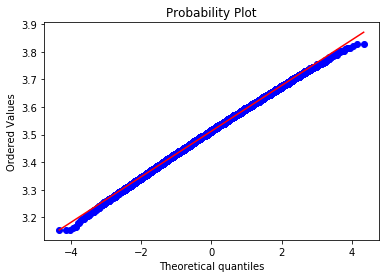

In [49]:
stats.probplot(DC_rating, dist="norm", plot=plt)
plt.show()

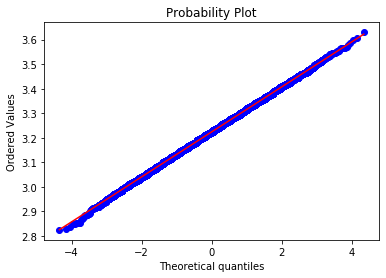

In [54]:
stats.probplot(MD_rating, dist="norm", plot=plt)
plt.show()

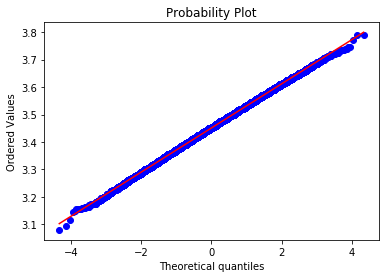

In [55]:
stats.probplot(VA_rating, dist="norm", plot=plt)
plt.show()

In [44]:
stats.f_oneway(DC_rating, MD_rating,VA_rating)

F_onewayResult(statistic=320582.82278036047, pvalue=0.0)

In [45]:
tukey_hsd([DC_rating,MD_rating,VA_rating],['DC','MD','VA'],'rating')[1]
# MD has highest rating then VA then DC

group1,group2,meandiff,lower,upper,reject
DC,MD,-0.2886,-0.2895,-0.2877,True
DC,VA,-0.0614,-0.0623,-0.0605,True
MD,VA,0.2272,0.2263,0.2281,True


In [74]:
# split the rows 
def split_rows(df, col1, col2, sep):
    '''
    input: 
    df: dataframe to use
    col1 and col2 (use col2 to split )
    return:
    a df table with col1 as common col and col2 split into multiple rows
    '''
    series = [pd.Series(row[col1], row[col2].split(sep))
              for _, row in df.iterrows()]
    table = pd.concat(series).reset_index()
    return table

In [77]:
table = split_rows(df_location_price,'Lat', 'categories', '|')
table = table.rename(columns = {'index': 'category', 0: 'Lat'})

In [79]:
# join table 
mergedtable = pd.merge(df_location_price,table, on = 'Lat')

In [100]:
filtered_df = mergedtable[(mergedtable.category=='Bars')|(mergedtable.category =='Ramen')]

In [109]:
counts = filtered_df.groupby(['state','category']).size().reset_index()

In [112]:
table= counts.pivot(index = 'state', columns='category', values=0)

In [114]:
table.head()

category,Bars,Ramen
state,,
DC,221,46
MD,61,8
VA,143,19


In [115]:
dc = [221,46]
md = [61, 8]
va = [143,19]
tables = np.array([dc,md,va])

In [116]:
tables

array([[221,  46],
       [ 61,   8],
       [143,  19]])

In [117]:
stats.chi2_contingency(tables)
# chi2 is 3.03
# p value is 0.218 > alpha (0.05)
# dof = 2 
# no depedency between location and ramen or bar 

(3.039371664444074, 0.218780609974467, 2, array([[227.86144578,  39.13855422],
        [ 58.88554217,  10.11445783],
        [138.25301205,  23.74698795]]))